<a href="https://colab.research.google.com/github/SelimSavas/low-light-segmentation-with-mirnet-yolov8-segment-anything/blob/main/MIRNet-YOLOv8-Segment-Anything-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 vs SAM Meta

## Library

In [ ]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

import random
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from tensorflow import keras

# Özel kayıp işlevini yeniden tanımlayın
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


# MirNet modelinizi yükleyin ve custom_objects argümanına özel kayıp işlevinizi geçin
mirnet_model = keras.models.load_model('/content/drive/MyDrive/mirnet_model.h5', custom_objects={'charbonnier_loss': charbonnier_loss,'peak_signal_noise_ratio':peak_signal_noise_ratio})


In [4]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_l"

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_l_0b3195.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_l_0b3195.pth ; exist: True


In [70]:
from roboflow import Roboflow
rf = Roboflow(api_key="Pho4XVVaJnNcR3y3HNrK")
project = rf.workspace("owen-hui").project("night-traffic")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.90, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to night-traffic-2 in yolov8:: 100%|██████████| 128/128 [00:00<00:00, 2251.31it/s]


In [97]:
low_light_image = Image.open('/content/EkOTCnsWkAUGuFz.jpg_large')
low_light_image = low_light_image.resize((1200,800),Image.NEAREST)
low_light_image = np.uint32(low_light_image)
low_light_image.shape

(800, 1200, 3)

In [98]:
image = keras.preprocessing.image.img_to_array(low_light_image)
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis = 0)
image = mirnet_model.predict(image)
image = image[0] * 255.0
image = image.clip(0,255)
image = image.reshape((np.shape(image)[0],np.shape(image)[1],3))
image = np.uint32(image)
image.shape

1/1 [==============================] - 3s 3s/step


(800, 1200, 3)

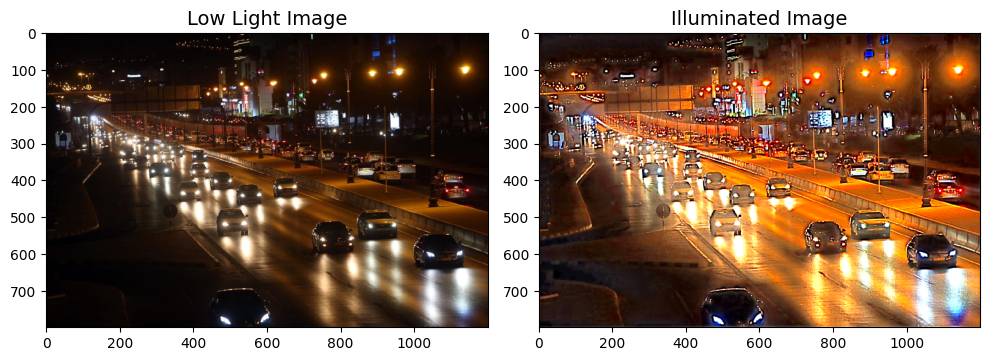

In [99]:
# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image, image]

# Başlık dizisi oluşturun
titles = ['Low Light Image', 'Illuminated Image']

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

## YoloV8 - Creating BBox

In [100]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')

results = yolo_model.predict(source=low_light_image.astype(np.uint8))

boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))


0: 448x640 18 cars, 1 traffic light, 69.0ms
Speed: 3.1ms preprocess, 69.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


In [101]:
boxes

array([[     996.13,      545.06,      1135.9,      639.63],
       [     841.85,      479.02,      955.13,      560.84],
       [     462.57,      476.59,       551.9,      552.83],
       [     515.61,      412.04,      585.91,      469.55],
       [     719.86,       510.3,      839.35,      599.36],
       [     438.69,      691.66,      612.74,      797.13],
       [     616.05,       390.3,      684.78,      446.38],
       [     443.33,      376.79,      510.04,      427.55],
       [     355.64,      402.35,      421.44,      457.58],
       [     279.68,      351.84,      335.45,      394.22],
       [     389.09,       350.1,      444.02,      396.74],
       [     317.33,      464.02,      357.54,      504.44],
       [      887.4,      357.86,      965.54,      409.69],
       [     684.66,      320.14,      732.82,      351.17],
       [     794.19,      337.58,       858.5,       381.7],
       [     831.03,      352.62,      894.64,      393.12],
       [     395.32,    

In [102]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

In [ ]:
low_light_image = low_light_image.astype(np.uint8)
low_segmented_image = low_light_image.copy()
low_box_image = low_light_image.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'5':sv.Color.blue() ,'7':sv.Color.black(),'8':sv.Color.green(),'9':sv.Color.blue()}
mask_predictor.set_image(low_light_image)

boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

In [ ]:
boxes.shape[0]

In [ ]:
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(low_light_image.shape),
    multimask_output=True
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )
    
    detections = detections[detections.area == np.max(detections.area)]
    low_box_image = box_annotator.annotate(scene=low_box_image, detections=detections, skip_label=True)
    low_segmented_image = mask_annotator.annotate(scene=low_segmented_image, detections=detections)
    i += 1

# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image,low_box_image, low_segmented_image]

# Başlık dizisi oluşturun
titles = ['Low Light Image','Box Image', 'Segmented Image']

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [93]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')
results = yolo_model.predict(source=image.astype(np.uint8))

boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))


0: 448x640 4 cars, 2 traffic lights, 75.3ms
Speed: 2.5ms preprocess, 75.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


In [94]:
image = image.astype(np.uint8)
segmented_image = image.copy()
box_image = image.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'5':sv.Color.blue() ,'7':sv.Color.black(),'8':sv.Color.green(),'9':sv.Color.green()}
image_array = np.array(image)
mask_predictor.set_image(image_array)

boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([6, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7feb520bf560>
tensor([[713.4669, 445.4834, 767.7342, 509.2821],
        [692.1627, 336.9004, 729.2665, 367.7298],
        [742.6827, 303.8230, 764.5236, 323.0974],
        [710.0073, 143.6739, 730.8704, 174.4266],
        [622.8168, 313.6398, 644.3361, 330.6675],
        [428.8288, 282.3130, 444.9015, 298.3060]], device='cuda:0')


In [95]:
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(image.shape),
    multimask_output=True
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )
    
    detections = detections[detections.area == np.max(detections.area)]
    box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)
    i += 1


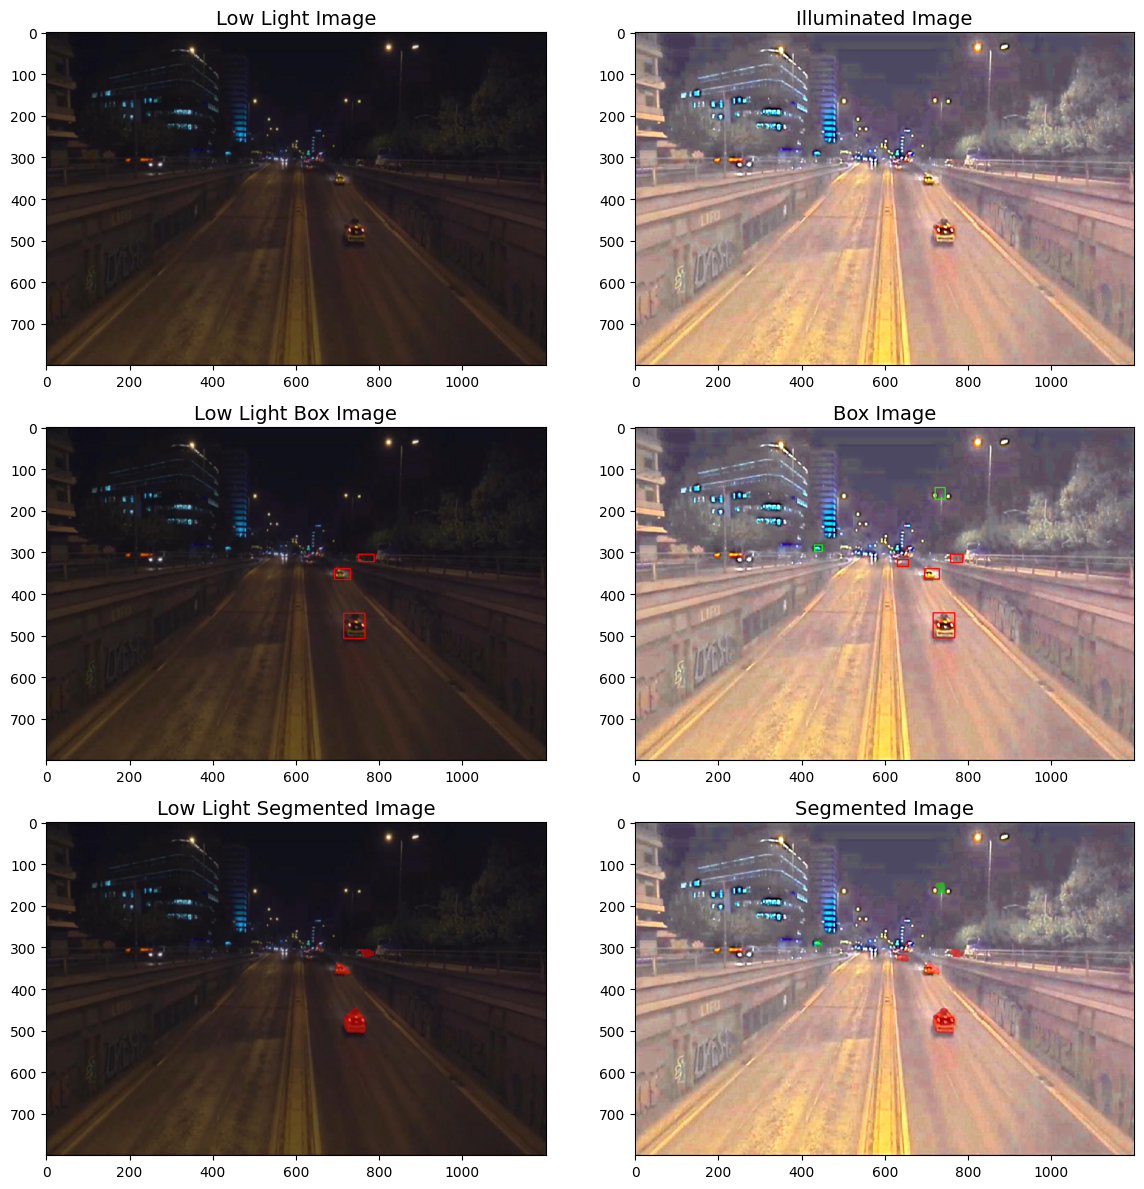

In [96]:

# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image, image, low_box_image,box_image, low_segmented_image, segmented_image]

# Başlık dizisi oluşturun
titles = ['Low Light Image', 'Illuminated Image', 'Low Light Box Image','Box Image', 'Low Light Segmented Image', 'Segmented Image' ]

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()